# Import Library and Helper Functions

In [15]:
%load_ext autoreload
%autoreload 2

In [178]:
import joblib
import os
import pickle
import sys
import warnings

# redirect path
sys.path.append('/workspace')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.metrics._classification import UndefinedMetricWarning
from sklearn.model_selection import train_test_split
from seaborn import set, set_style
from typing import Tuple, Union

# import helper as hp
from metrics import get_metrics

# set graphs style
set()
set_style(style="white")

# silence UndefineMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [183]:
def plot_cm_auroc(
    df: pd.DataFrame,
    figsize: tuple = (18, 35),
    font_scale: int = 2,
    fontsize: int = 25,
    legend_fontsize: int = 22,
    vmin: Union[int, float] = 63,
    vmax: Union[int, float] = 93217,
    
):

    sns.set(font_scale=font_scale)
    names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    row_n = 0

    fig, axes = plt.subplots(len(df), 2, figsize=figsize)
    for row in df.itertuples():
        title = row.classifiers + " and " + row.samplings
        fpr = row.fprs
        tpr = row.tprs
        # set axes
        if len(df) == 1:
            ax_cm = axes[0]
            ax_auroc = axes[1]
        else:
            ax_cm = axes[row_n, 0]
            ax_auroc = axes[row_n, 1]

        ### CONFUSION MATRIX ###
        # prepare annotations for the confusion matrix
        conf_mat = row.conf_mat
        counts = conf_mat.ravel()
        percents = (counts / np.sum(conf_mat) * 100).round(2)
        labels = [
            f"{name}\n{count}\n{percent}%"
            for name, count, percent in zip(names, counts, percents)
        ]
        size = int(np.sqrt(len(labels)))
        annot = np.asarray(labels).reshape(size, size)
        
        # create mask
        mask_true = np.asarray(
            [
                label.startswith("True Neg") or label.startswith("True Pos")
                for label in labels
            ]
        ).reshape(size, size)
        mask_false = np.asarray(
            [
                label.startswith("False Neg") or label.startswith("False Pos")
                for label in labels
            ]
        ).reshape(size, size)
        
        # plot confusion matrix
        sns.heatmap(row.conf_mat, cbar=False, ax=ax_cm,
                   ).set_title(
            f"Confusion Matrix of \n{title}", fontsize=fontsize,
        )
        sns.heatmap(
            row.conf_mat,
            mask=mask_true,
            annot=annot,
            fmt="",
            cbar=False,
            vmin=vmin,
            vmax=vmax,
            cmap="Reds",
            ax=ax_cm,
        )
        sns.heatmap(
            row.conf_mat,
            mask=mask_false,
            annot=annot,
            fmt="",
            cbar=False,
            vmin=vmin,
            vmax=vmax,
            cmap="Greens",
            ax=ax_cm,
        )

        #### AUROC ###
        ax = ax_auroc
        # calculate and print best RC threshold
        J = tpr - fpr
        idx = np.argmax(J)
        best_thresh = row.thresholds_rocs[idx]
        # plt no skill roc curve - the diagonal line
        ax.plot([0, 1], [0, 1], linestyle="--", label="No Skill")
        # plt roc curve
        ax.plot(
            fpr,
            tpr,
            marker=".",
            label=f"F1: {row.f1s: 0.2f}\nAUROC: {row.roc_aucs: .2f}\nBest ROC Threshold: {best_thresh:0.2f}",
        )
        # title and axis labels
        ax.set_title(f"AUROC of \n{title}", fontsize=fontsize)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        # show the legend
        ax.legend(fontsize=legend_fontsize, handleheight=3.0)

        row_n += 1

    plt.tight_layout()

# Préparation de Données

## Import le DataFrame Mergé

In [4]:
%%time
# import merged dataframe
df = pd.read_csv('../data/combined/combined.csv', index_col=0)
df_copy = df.copy()
print(df.shape)

(356251, 797)
CPU times: user 1min 46s, sys: 1min 49s, total: 3min 35s
Wall time: 3min 54s


In [7]:
# %%time
# df = df_copy.copy()

CPU times: user 3.54 s, sys: 13.2 s, total: 16.8 s
Wall time: 16.7 s


##  Nettoyage de Données
### Fill NA

In [8]:
df.tail()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
index,,,,,,,,,,,,,,,,,,,,,
48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,495000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48743,456250,NaN,1,1,1,0,135000.0,312768.0,24709.5,270000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0


In [5]:
%%time
df.iloc[:, 2:] = df.iloc[:, 2:].fillna(0)

CPU times: user 40.2 s, sys: 42.9 s, total: 1min 23s
Wall time: 1min 23s


In [10]:
df.tail()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
index,,,,,,,,,,,,,,,,,,,,,
48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,270000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,495000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,315000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48743,456250,NaN,1,1,1,0,135000.0,312768.0,24709.5,270000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0


In [11]:
%%time
df_no_nan = df.copy()

CPU times: user 1.92 s, sys: 1.5 s, total: 3.42 s
Wall time: 3.42 s


### Strip Infinite  Values

In [6]:
%%time
print("Original DataFrame Size: ",  df.shape)
df = df[~df.isin([np.inf, -np.inf]).any(1)]
print("Cleaned DataFrame Size:  ",  df.shape)

Original DataFrame Size:  (356251, 797)
Cleaned DataFrame Size:   (356231, 797)
CPU times: user 20.4 s, sys: 46.8 s, total: 1min 7s
Wall time: 1min 7s


In [7]:
%%time
df_no_inf = df.copy()

CPU times: user 12.2 s, sys: 887 ms, total: 13.1 s
Wall time: 13.1 s


## Split Train et Test Set

In [13]:
# %%time
# df = df_no_inf.copy()

CPU times: user 53.1 s, sys: 7.07 s, total: 1min
Wall time: 1min


In [10]:
%%time
# split train and test set
df = df[~df.TARGET.isnull()]
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, 2:], df.iloc[:, 1], test_size=0.33, random_state=42, stratify=df.TARGET
)
print("Shape of the train set:  ", X_train.shape)
print("Shape of the test set:   ", X_test.shape)
print("Shape of the train label:", y_train.shape)
print("Shape of the test label: ", y_test.shape)

Shape of the train set:   (206016, 795)
Shape of the test set:    (101472, 795)
Shape of the train label: (206016,)
Shape of the test label:  (101472,)
CPU times: user 45.4 s, sys: 1min 27s, total: 2min 13s
Wall time: 2min 19s


In [11]:
%%time
# split toy train and test set
df_toy = df[:50][~df[:50].TARGET.isnull()]
X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(
    df_toy.iloc[:, 2:],
    df_toy.iloc[:, 1],
    test_size=0.33,
    random_state=42,
    stratify=df_toy.TARGET,
)
print("Shape of the toy train set:  ", X_train_toy.shape)
print("Shape of the toy test set:   ", X_test_toy.shape)
print("Shape of the toy train label:", y_train_toy.shape)
print("Shape of the toy test label: ", y_test_toy.shape)

Shape of the toy train set:   (33, 795)
Shape of the toy test set:    (17, 795)
Shape of the toy train label: (33,)
Shape of the toy test label:  (17,)
CPU times: user 61.3 ms, sys: 0 ns, total: 61.3 ms
Wall time: 74.7 ms


In [13]:
%%time
# split toy train and test set (medium size)
df_toy_medium = df[:200][~df[:200].TARGET.isnull()]
X_train_toy_medium, X_test_toy_medium, y_train_toy_medium, y_test_toy_medium = train_test_split(
    df_toy_medium.iloc[:, 2:],
    df_toy_medium.iloc[:, 1],
    test_size=0.33,
    random_state=42,
    stratify=df_toy_medium.TARGET,
)
print("Shape of the medium toy train set:  ", X_train_toy_medium.shape)
print("Shape of the medium toy test set:   ", X_test_toy_medium.shape)
print("Shape of the medium toy train label:", y_train_toy_medium.shape)
print("Shape of the medium toy test label: ", y_test_toy_medium.shape)

Shape of the medium toy train set:   (134, 795)
Shape of the medium toy test set:    (66, 795)
Shape of the medium toy train label: (134,)
Shape of the medium toy test label:  (66,)
CPU times: user 244 ms, sys: 0 ns, total: 244 ms
Wall time: 242 ms


In [41]:
%%time
# split toy train and test set (1k size)
df_toy_1k = df[:1000][~df[:1000].TARGET.isnull()]
X_train_toy_1k, X_test_toy_1k, y_train_toy_1k, y_test_toy_1k = train_test_split(
    df_toy_1k.iloc[:, 2:],
    df_toy_1k.iloc[:, 1],
    test_size=0.33,
    random_state=42,
    stratify=df_toy_1k.TARGET,
)
print("Shape of the 1k toy train set:  ", X_train_toy_1k.shape)
print("Shape of the 1k toy test set:   ", X_test_toy_1k.shape)
print("Shape of the 1k toy train label:", y_train_toy_1k.shape)
print("Shape of the 1k toy test label: ", y_test_toy_1k.shape)

Shape of the 1k toy train set:   (670, 795)
Shape of the 1k toy test set:    (330, 795)
Shape of the 1k toy train label: (670,)
Shape of the 1k toy test label:  (330,)
CPU times: user 469 ms, sys: 0 ns, total: 469 ms
Wall time: 472 ms


In [42]:
%%time
# get rid of constant columnes, e.g., all 0s or all 1s
X = pd.concat([X_train_toy_1k, X_test_toy_1k])
X_no_all_zeros = X.filter(
    items=list(X.columns[~(X[: len(X_train_toy_1k)] == 0).all()].values)
)
X_no_constant = X_no_all_zeros.filter(
    items=list(
        X_no_all_zeros.columns[~(X_no_all_zeros[: len(X_train_toy_1k)] == 1).all()].values
    )
)
X_train_toy_1k = X_no_constant[: len(X_train_toy_1k)]
X_test_toy_1k = X_no_constant[len(X_train_toy_1k) :]

print("Shape of the 1k toy train set:  ", X_train_toy_1k.shape)
print("Shape of the 1k toy test set:   ", X_test_toy_1k.shape)
print("Shape of the 1k toy train label:", y_train_toy_1k.shape)
print("Shape of the 1k toy test label: ", y_test_toy_1k.shape)

Shape of the 1k toy train set:   (670, 683)
Shape of the 1k toy test set:    (330, 683)
Shape of the 1k toy train label: (670,)
Shape of the 1k toy test label:  (330,)
CPU times: user 78.9 ms, sys: 24.2 ms, total: 103 ms
Wall time: 105 ms


In [11]:
%%time
# split toy train and test set (half size)
df_toy_half = df[:int(len(df)/2)][~df[:int(len(df)/2)].TARGET.isnull()]
X_train_toy_half, X_test_toy_half, y_train_toy_half, y_test_toy_half = train_test_split(
    df_toy_half.iloc[:, 2:],
    df_toy_half.iloc[:, 1],
    test_size=0.33,
    random_state=42,
    stratify=df_toy_half.TARGET,
)
print("Shape of the half toy train set:  ", X_train_toy_half.shape)
print("Shape of the half toy test set:   ", X_test_toy_half.shape)
print("Shape of the half toy train label:", y_train_toy_half.shape)
print("Shape of the half toy test label: ", y_test_toy_half.shape)

Shape of the half toy train set:   (119337, 795)
Shape of the half toy test set:    (58778, 795)
Shape of the half toy train label: (119337,)
Shape of the half toy test label:  (58778,)
CPU times: user 5.45 s, sys: 3.09 s, total: 8.54 s
Wall time: 8.55 s


In [11]:
%%time
# split toy train and test set (0.75 of the full ds)
df_toy_75 = df[:int(len(df)*0.75)][~df[:int(len(df)*0.75)].TARGET.isnull()]
X_train_toy_75, X_test_toy_75, y_train_toy_75, y_test_toy_75 = train_test_split(
    df_toy_75.iloc[:, 2:],
    df_toy_75.iloc[:, 1],
    test_size=0.33,
    random_state=42,
    stratify=df_toy_75.TARGET,
)
print("Shape of the 75 toy train set:  ", X_train_toy_75.shape)
print("Shape of the 75 toy test set:   ", X_test_toy_75.shape)
print("Shape of the 75 toy train label:", y_train_toy_75.shape)
print("Shape of the 75 toy test label: ", y_test_toy_75.shape)

Shape of the big toy train set:   (179005, 795)
Shape of the big toy test set:    (88168, 795)
Shape of the big toy train label: (179005,)
Shape of the big toy test label:  (88168,)
CPU times: user 22.3 s, sys: 55.8 s, total: 1min 18s
Wall time: 1min 18s


In [8]:
%%time
# keep only 25% of the dataset
df = df[~df.TARGET.isnull()]
(
    X_25_stratified,
    X_do_not_keep,
    y_25_stratified,
    y_do_not_keep,
) = train_test_split(
    df.iloc[:, 2:], df.iloc[:, 1], train_size=0.25, random_state=42, stratify=df.TARGET
)
print("Shape of the keep set:       ", X_25_stratified.shape)
print("Shape of the not keep set:   ", X_do_not_keep.shape)
print("Shape of the keep label:     ", y_25_stratified.shape)
print("Shape of the not keep label: ", y_do_not_keep.shape)

Shape of the keep set:   (76872, 795)
Shape of the not keep set:    (230616, 795)
Shape of the keep label: (76872,)
Shape of the not keep label:  (230616,)
CPU times: user 21.9 s, sys: 1min 17s, total: 1min 39s
Wall time: 1min 40s


In [21]:
%%time
# split train and test set
(
    X_train_25_stratified,
    X_test_25_stratified,
    y_train_25_stratified,
    y_test_25_stratified,
) = train_test_split(
    X_25_stratified,
    y_25_stratified,
    train_size=0.75,
    random_state=42,
    stratify=y_25_stratified,
)
print("Shape of the train set:  ", X_train_25_stratified.shape)
print("Shape of the test set:   ", X_test_25_stratified.shape)
print("Shape of the train label:", y_train_25_stratified.shape)
print("Shape of the test label: ", y_test_25_stratified.shape)

Shape of the train set:   (57654, 795)
Shape of the test set:    (19218, 795)
Shape of the train label: (57654,)
Shape of the test label:  (19218,)
CPU times: user 6.47 s, sys: 0 ns, total: 6.47 s
Wall time: 6.48 s


In [39]:
%%time
# get rid of constant columnes, e.g., all 0s or all 1s
X = pd.concat([X_train_25_stratified, X_test_25_stratified])
X_no_all_zeros = X.filter(
    items=list(X.columns[~(X[: len(X_train_25_stratified)] == 0).all()].values)
)
X_no_constant = X_no_all_zeros.filter(
    items=list(
        X_no_all_zeros.columns[~(X_no_all_zeros[: len(X_train_25_stratified)] == 1).all()].values
    )
)
X_train_25_stratified = X_no_constant[: len(X_train_25_stratified)]
X_test_25_stratified = X_no_constant[len(X_train_25_stratified) :]

print("Shape of the train set:  ", X_train_25_stratified.shape)
print("Shape of the test set:   ", X_test_25_stratified.shape)
print("Shape of the train label:", y_train_25_stratified.shape)
print("Shape of the test label: ", y_test_25_stratified.shape)

Shape of the train set:   (57654, 758)
Shape of the test set:    (19218, 758)
Shape of the train label: (57654,)
Shape of the test label:  (19218,)
CPU times: user 815 ms, sys: 17.2 s, total: 18 s
Wall time: 18.5 s


In [16]:
%%time
# split train and test set
df = df[~df.TARGET.isnull()]
(
    X_train_half_stratified,
    X_test_half_stratified,
    y_train_half_stratified,
    y_test_half_stratified,
) = train_test_split(
    df.iloc[:, 2:], df.iloc[:, 1], test_size=0.5, random_state=42, stratify=df.TARGET
)
print("Shape of the train set:  ", X_train_half_stratified.shape)
print("Shape of the test set:   ", X_test_half_stratified.shape)
print("Shape of the train label:", y_train_half_stratified.shape)
print("Shape of the test label: ", y_test_half_stratified.shape)

Shape of the train set:   (153744, 795)
Shape of the test set:    (153744, 795)
Shape of the train label: (153744,)
Shape of the test label:  (153744,)
CPU times: user 13.6 s, sys: 18 s, total: 31.6 s
Wall time: 31.6 s


# Save Datasets

In [13]:
%%time
# save DatFrames
X_train.to_csv("data/train/X_train.csv", index=False)
X_test.to_csv("data/train/X_test.csv", index=False)
y_train.to_csv("data/train/y_train.csv", index=False)
y_test.to_csv("data/train/y_test.csv", index=False)
# save toy DatFrames
X_train_toy.to_csv("data/train_toy/X_train_toy.csv", index=False)
X_test_toy.to_csv("data/train_toy/X_test_toy.csv", index=False)
y_train_toy.to_csv("data/train_toy/y_train_toy.csv", index=False)
y_test_toy.to_csv("data/train_toy/y_test_toy.csv", index=False)

CPU times: user 4min 36s, sys: 10.6 s, total: 4min 46s
Wall time: 7min 51s


In [26]:
%%time
# save medium toy DatFrames
X_train_toy_medium.to_csv("data/train_toy_medium/X_train_toy_medium.csv", index=False)
X_test_toy_medium.to_csv("data/train_toy_medium/X_test_toy_medium.csv", index=False)
y_train_toy_medium.to_csv("data/train_toy_medium/y_train_toy_medium.csv", index=False)
y_test_toy_medium.to_csv("data/train_toy_medium/y_test_toy_medium.csv", index=False)

CPU times: user 106 ms, sys: 4.1 ms, total: 110 ms
Wall time: 177 ms


In [44]:
%%time
# save 1k toy DatFrames
X_train_toy_1k.to_csv("../data/train_toy_1k/X_train_toy_1k.csv", index=False)
X_test_toy_1k.to_csv("../data/train_toy_1k/X_test_toy_1k.csv", index=False)
y_train_toy_1k.to_csv("../data/train_toy_1k/y_train_toy_1k.csv", index=False)
y_test_toy_1k.to_csv("../data/train_toy_1k/y_test_toy_1k.csv", index=False)

CPU times: user 609 ms, sys: 36.6 ms, total: 646 ms
Wall time: 1.56 s


In [13]:
%%time
# save half toy DatFrames
X_train_toy_half.to_csv("../data/train_toy_half/X_train_toy_half.csv", index=False)
X_test_toy_half.to_csv("../data/train_toy_half/X_test_toy_half.csv", index=False)
y_train_toy_half.to_csv("../data/train_toy_half/y_train_toy_half.csv", index=False)
y_test_toy_half.to_csv("../data/train_toy_half/y_test_toy_half.csv", index=False)

CPU times: user 2min 11s, sys: 7.03 s, total: 2min 18s
Wall time: 3min 28s


In [16]:
%%time
# save big toy DatFrames
X_train_toy_75.to_csv("../data/train_toy_big/X_train_toy_big.csv", index=False)
X_test_toy_75.to_csv("../data/train_toy_big/X_test_toy_big.csv", index=False)
y_train_toy_75.to_csv("../data/train_toy_big/y_train_toy_big.csv", index=False)
y_test_toy_75.to_csv("../data/train_toy_big/y_test_toy_big.csv", index=False)

CPU times: user 3min 53s, sys: 10 s, total: 4min 3s
Wall time: 6min 44s


In [40]:
%%time
# save 25 stratified DatFrames
X_train_25_stratified.to_csv("../data/train_25_stratified/X_train_25_stratified.csv", index=False)
X_test_25_stratified.to_csv("../data/train_25_stratified/X_test_25_stratified.csv", index=False)
y_train_25_stratified.to_csv("../data/train_25_stratified/y_train_25_stratified.csv", index=False)
y_test_25_stratified.to_csv("../data/train_25_stratified/y_test_25_stratified.csv", index=False)

CPU times: user 49.4 s, sys: 2.96 s, total: 52.4 s
Wall time: 2min 18s


In [18]:
%%time
# save half stratified DatFrames
X_train_half_stratified.to_csv("../data/train_half_stratified/X_train_half_stratified.csv", index=False)
X_test_half_stratified.to_csv("../data/train_half_stratified/X_test_half_stratified.csv", index=False)
y_train_half_stratified.to_csv("../data/train_half_stratified/y_train_half_stratified.csv", index=False)
y_test_half_stratified.to_csv("../data/train_half_stratified/y_test_half_stratified.csv", index=False)

CPU times: user 4min 16s, sys: 14.7 s, total: 4min 30s
Wall time: 7min 28s


# Modèle de Référence

In [17]:
%%time
# get DataFrames
X_train = pd.read_csv("../data/train/X_train.csv")
y_train = pd.read_csv("../data/train/y_train.csv")
X_test = pd.read_csv("../data/train/X_test.csv")
y_test = pd.read_csv("../data/train/y_test.csv")

# # get toy DataFrames
# X_train_toy = pd.read_csv("../data/train_toy/X_train_toy.csv")
# y_train_toy = pd.read_csv("../data/train_toy/y_train_toy.csv")
# X_test_toy = pd.read_csv("../data/train_toy/X_test_toy.csv")
# y_test_toy = pd.read_csv("../data/train_toy/y_test_toy.csv")

# # get medium toy_medium DataFrames
# X_train_toy_medium = pd.read_csv("../data/train_toy_medium/X_train_toy_medium.csv")
# y_train_toy_medium = pd.read_csv("../data/train_toy_medium/y_train_toy_medium.csv")
# X_test_toy_medium = pd.read_csv("../data/train_toy_medium/X_test_toy_medium.csv")
# y_test_toy_medium = pd.read_csv("../data/train_toy_medium/y_test_toy_medium.csv")

# # get half toy_half DataFrames
# X_train_toy_half = pd.read_csv("../data/train_toy_half/X_train_toy_half.csv")
# y_train_toy_half = pd.read_csv("../data/train_toy_half/y_train_toy_half.csv")
# X_test_toy_half = pd.read_csv("../data/train_toy_half/X_test_toy_half.csv")
# y_test_toy_half = pd.read_csv("../data/train_toy_half/y_test_toy_half.csv")

CPU times: user 46.3 s, sys: 27 s, total: 1min 13s
Wall time: 1min 13s


In [188]:
%%time
# Dummy Classifier
dc = DummyClassifier(strategy="most_frequent", random_state=1)
dc.fit(X_train, y_train)
preds = dc.predict(X_test)
scores = dc.predict_proba(X_test)

CPU times: user 75.5 ms, sys: 2.65 ms, total: 78.2 ms
Wall time: 76.7 ms


In [189]:
%%time
# get metrics
(
    acc,
    prec,
    recall,
    f1,
    fpr,
    tpr,
    thresholds_roc,
    roc_auc,
    prec_pr,
    recall_pr,
    thresholds_pr,
    confusion_matrix,
) = get_metrics(y_test, preds, scores[:, 1])
print("Accuracy:    ", acc)
print("Precision:   ", prec)
print("Recall:      ", recall)
print("F1 Score:    ", f1)

Accuracy:     0.9192683695994954
Precision:    0.0
Recall:       0.0
F1 Score:     0.0
CPU times: user 296 ms, sys: 513 µs, total: 296 ms
Wall time: 302 ms


In [190]:
# declare variables
classifier = "Baseline"
sampling = "na"
features_reduction = "na"

# create df
baseline_metrics_df = pd.DataFrame(
    [
        classifier,
        sampling,
        features_reduction,
        preds,
        scores,
        acc,
        prec,
        recall,
        f1,
        fpr,
        tpr,
        thresholds_roc,
        roc_auc,
        prec_pr,
        recall_pr,
        thresholds_pr,
        confusion_matrix,
    ],
    index=[
        "classifiers",
        "samplings",
        "features_reductions",
        "preds",
        "scores",
        "accuracies",
        "precisions",
        "recalls",
        "f1s",
        "fprs",
        "tprs",
        "thresholds_rocs",
        "roc_aucs",
        "prec_prs",
        "recall_prs",
        "thresholds_prs",
        "conf_mat",
    ],
).T

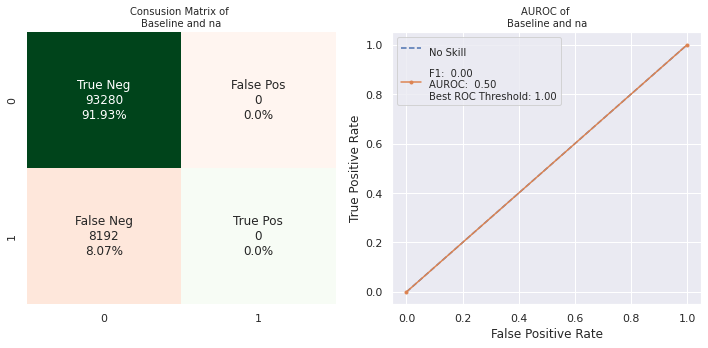

CPU times: user 709 ms, sys: 281 ms, total: 989 ms
Wall time: 564 ms


In [191]:
%%time
# visualize metrics
plot_cm_auroc(
    baseline_metrics_df, figsize=(10, 5), font_scale=1, fontsize=10, legend_fontsize=10
)
plt.show()

# Custom Metric: Recall  Weight to Specificity  Weight Ratio  = 9 : 1

## Combiner les Métrics

In [67]:
# read metric files
files = [
    file
    for file in os.listdir("../results/recall_90_spec_10")
    if file.startswith("full")
]
metrics = {}

for file in files:
    with open(os.path.join("../results/recall_90_spec_10/", file), "rb") as f:
        metrics[file.split("_", 1)[1:][0].rsplit("_", 1)[0]] = pickle.load(f)
len(metrics)

7

In [247]:
# concat all the metric files into 1 dataframe
df_metrics_9_vs_1 = pd.concat(
    [metrics[key] for key in metrics.keys()]
)
df_metrics_9_vs_1.reset_index(drop=True, inplace=True)
df_metrics_9_vs_1.shape

(12, 19)

In [248]:
# save combined metric df
with open("../results/recall_90_spec_10/all.pkl", "wb") as f:
    pickle.dump(df_metrics_9_vs_1, f)

In [149]:
# read combined metric df
with open("../results/recall_90_spec_10/all.pkl", "rb") as f:
    df_metrics_9_vs_1 = pickle.load(f)

In [150]:
# rank and visualized import metrics
df_metrics_9_vs_1_small = df_metrics_9_vs_1[
    [
        "classifiers",
        "samplings",
        "features_reductions",
        "accuracies",
        "precisions",
        "recalls",
        "f1s",
        "roc_aucs",
        "custom_scores",
        "durations",
    ]
]
df_metrics_9_vs_1_small.sort_values(by="roc_aucs", ascending=False)

,classifiers,samplings,features_reductions,accuracies,precisions,recalls,f1s,roc_aucs,custom_scores,durations
1,LGBMClassifier,ClassWeight,NA,0.533615,0.131092,0.848755,0.227107,0.765736,0.185527,35.408108
6,RandomForestClassifier,ClassWeight,NA,0.688771,0.159816,0.670654,0.258122,0.747735,0.327375,98.966086
4,LogisticRegression,ClassWeight,SelectKBest,0.526076,0.127094,0.829956,0.220432,0.744955,0.203101,41.327384
3,LogisticRegression,SMOTE,SelectKBest,0.687638,0.158947,0.668579,0.256835,0.740593,0.329348,86.563667
2,LGBMClassifier,SMOTE,NA,0.915888,0.105747,0.005615,0.010664,0.695234,0.895363,128.842662
11,SGDClassifier,ClassWeight,SelectKBest,0.454076,0.109161,0.804688,0.192243,0.680748,0.233453,9.999378
9,SGDClassifier,SMOTE,SelectKBest,0.543815,0.118241,0.720215,0.203133,0.676085,0.298974,31.075763
8,RandomForestClassifier,SMOTE,NA,0.829963,0.17119,0.287964,0.214728,0.675603,0.653076,98.439752
5,LogisticRegression,NearMiss,SelectKBest,0.249182,0.082479,0.819824,0.149879,0.563444,0.242251,124.526985
0,LGBMClassifier,NearMiss,NA,0.244235,0.084932,0.855469,0.154523,0.54478,0.211023,158.763793


## Les 4 Meilleurs Modèles

In [151]:
# get top 4 models
winning_model_df_9_vs_1 = df_metrics_9_vs_1.sort_values(
    by="roc_aucs", ascending=False
).head(4)

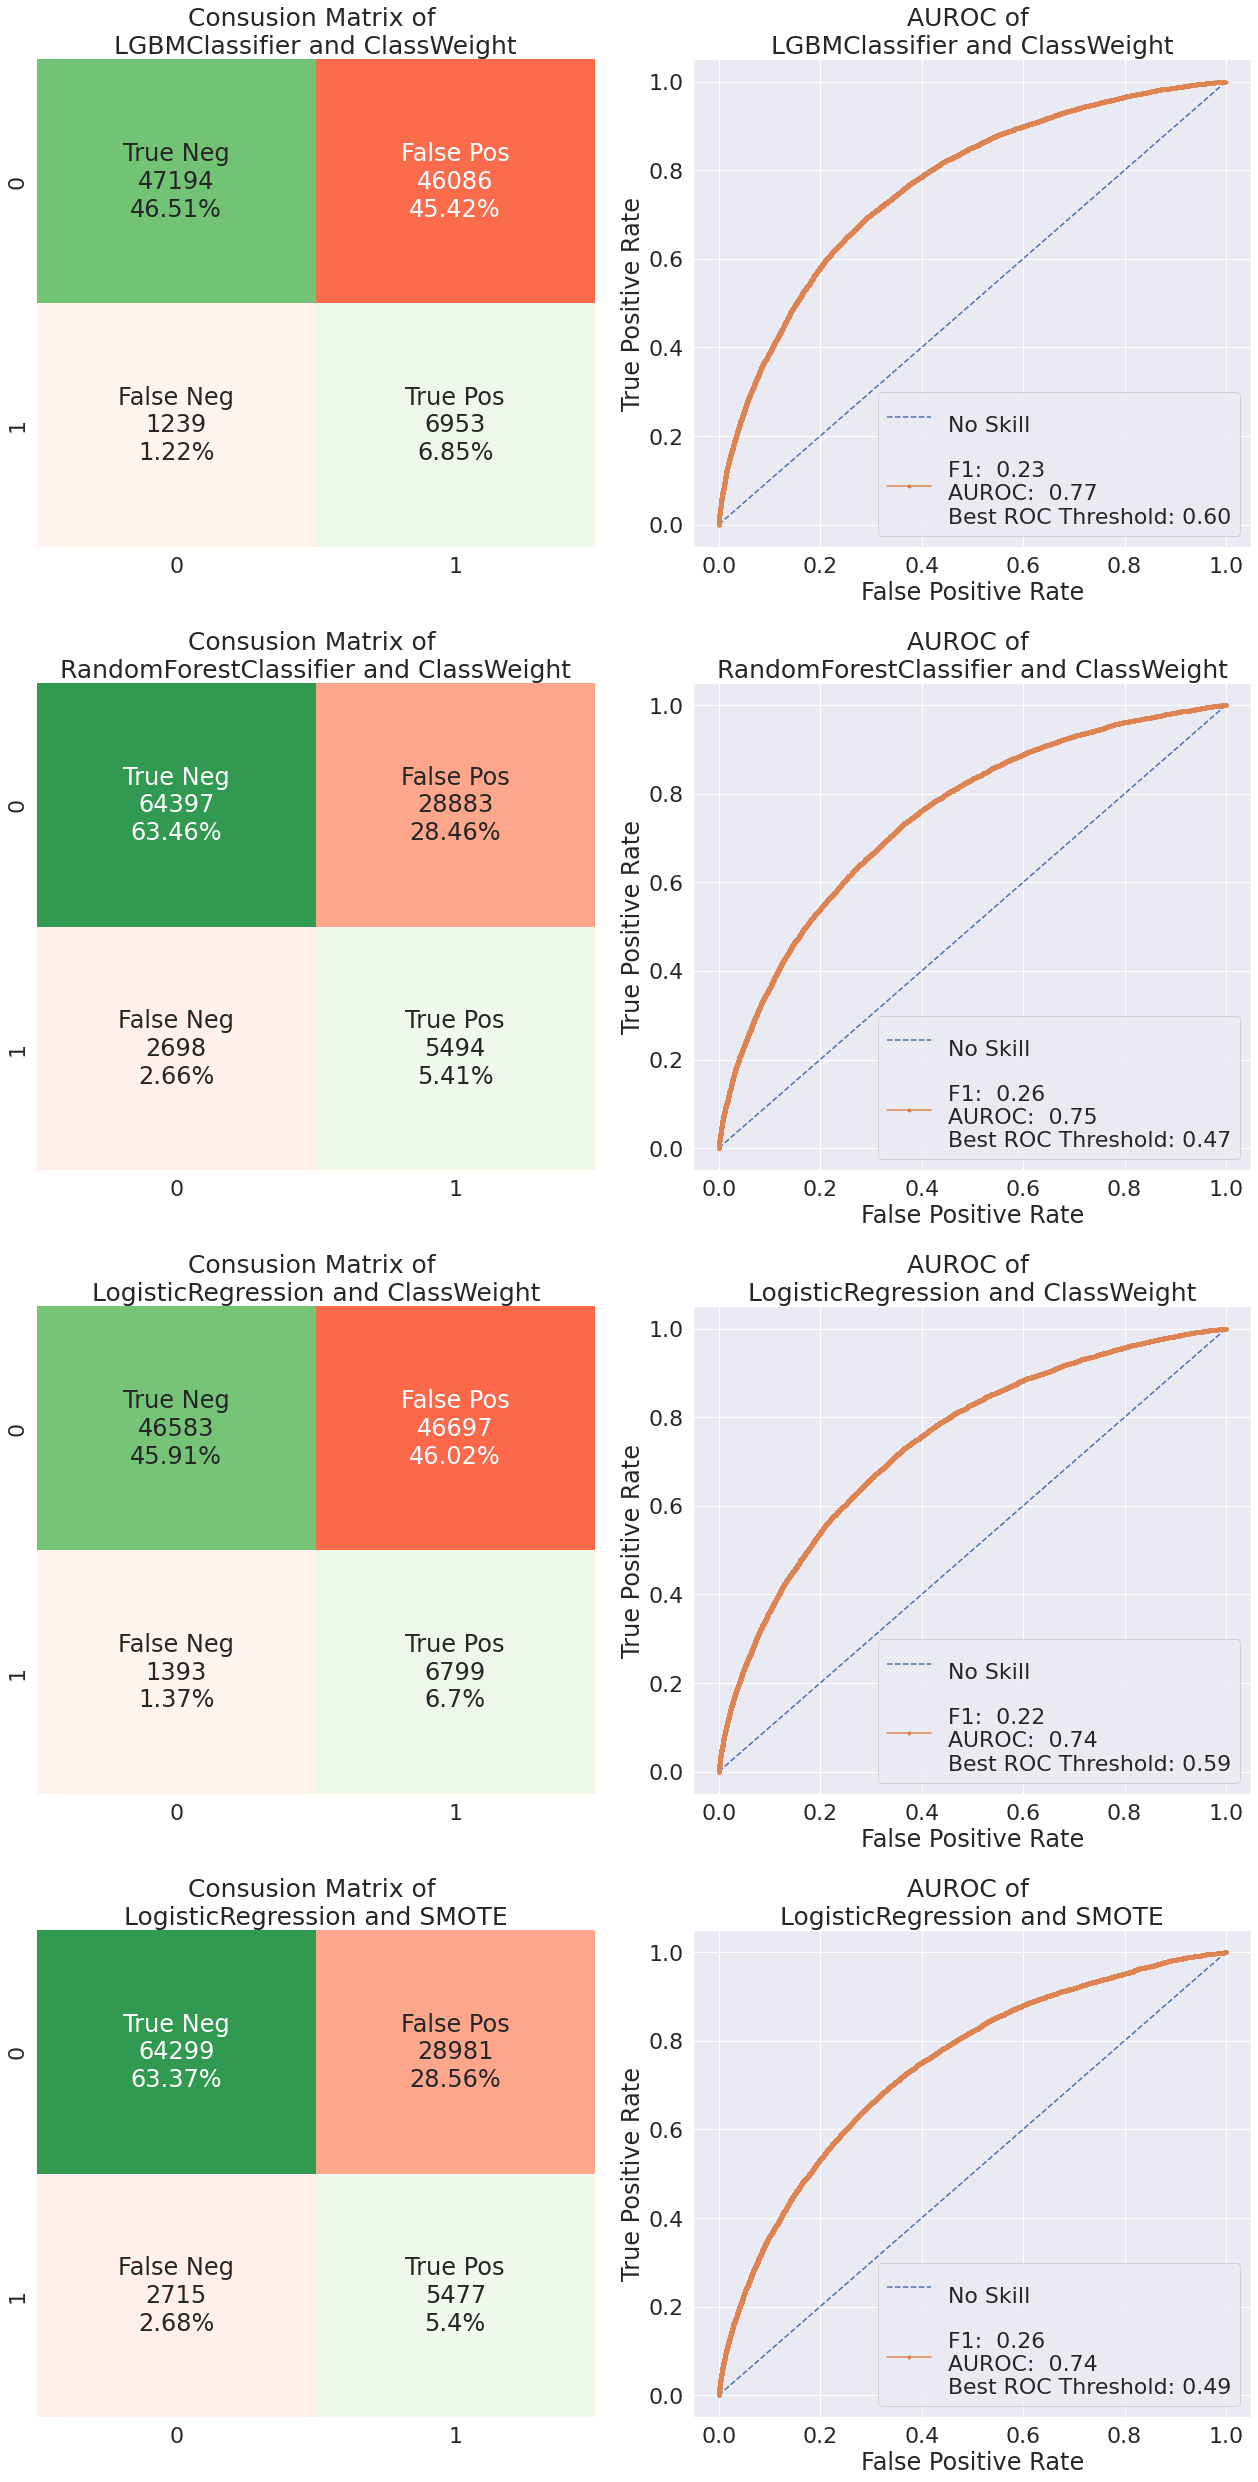

CPU times: user 4.64 s, sys: 358 ms, total: 5 s
Wall time: 4.49 s


In [185]:
%%time
# visualize metrics
plot_cm_auroc(winning_model_df_9_vs_1)
plt.show()

# Custom Metric: Recall  Weight to Specificity  Weight Ratio  = 7.5 : 2.5

## Combiner les Métrics

In [18]:
# read metric files
files = [
    file
    for file in os.listdir("../results/recall_75_spec_25")
    if file.startswith("full")
]
metrics = {}

for file in files:
    with open(os.path.join("../results/recall_75_spec_25/", file), "rb") as f:
        metrics[file.split("_", 1)[1:][0].rsplit("_", 1)[0]] = pickle.load(f)
len(metrics)

3

In [599]:
# concat all the metric files into 1 dataframe
df_metrics_75_vs_25 = pd.concat(
    [metrics[key] for key in metrics.keys()]
)
df_metrics_75_vs_25.reset_index(drop=True, inplace=True)
df_metrics_75_vs_25.shape

(12, 19)

In [600]:
# save combined metric df
with open("../results/recall_75_spec_25/all.pkl", "wb") as f:
    pickle.dump(df_metrics_75_vs_25, f)

In [19]:
# read combined metric df
with open("../results/recall_75_spec_25/all.pkl", "rb") as f:
    df_metrics_75_vs_25 = pickle.load(f)

In [20]:
# rank and visualized import metrics
df_metrics_75_vs_25_small = df_metrics_75_vs_25[
    [
        "classifiers",
        "samplings",
        "features_reductions",
        "accuracies",
        "precisions",
        "recalls",
        "f1s",
        "roc_aucs",
        "custom_scores",
        "durations",
    ]
]
df_metrics_75_vs_25_small.sort_values(by="roc_aucs", ascending=False)

,classifiers,samplings,features_reductions,accuracies,precisions,recalls,f1s,roc_aucs,custom_scores,durations
1,LGBMClassifier,ClassWeight,NA,0.593947,0.144178,0.816406,0.245076,0.775109,0.244093,29.680649
2,LGBMClassifier,SMOTE,NA,0.919465,0.568493,0.010132,0.019909,0.762021,0.74257,141.573494
3,RandomForestClassifier,ClassWeight,NA,0.703091,0.164217,0.654785,0.262581,0.745759,0.332078,48.564872
7,LogisticRegression,ClassWeight,SelectKBest,0.534009,0.128302,0.823608,0.222017,0.744959,0.25515,47.955657
8,LogisticRegression,SMOTE,SelectKBest,0.686781,0.158547,0.668579,0.256312,0.740465,0.326471,90.597354
11,SGDClassifier,SMOTE,SelectKBest,0.619373,0.137649,0.705566,0.230357,0.716143,0.317874,13.900785
10,SGDClassifier,ClassWeight,SelectKBest,0.490776,0.115521,0.797363,0.201804,0.70095,0.286015,12.429036
6,RandomForestClassifier,SMOTE,NA,0.903313,0.246159,0.095825,0.137949,0.686724,0.684574,656.325475
4,LogisticRegression,NearMiss,SelectKBest,0.249005,0.082573,0.821167,0.150057,0.565767,0.334436,123.41723
0,LGBMClassifier,NearMiss,NA,0.237829,0.084867,0.862793,0.154534,0.536805,0.307169,164.9372


## Les 4 Meilleurs Modèles

In [21]:
# get top 4 models
winning_model_df_75_vs_25 = df_metrics_75_vs_25.sort_values(
    by="roc_aucs", ascending=False
).head(4)

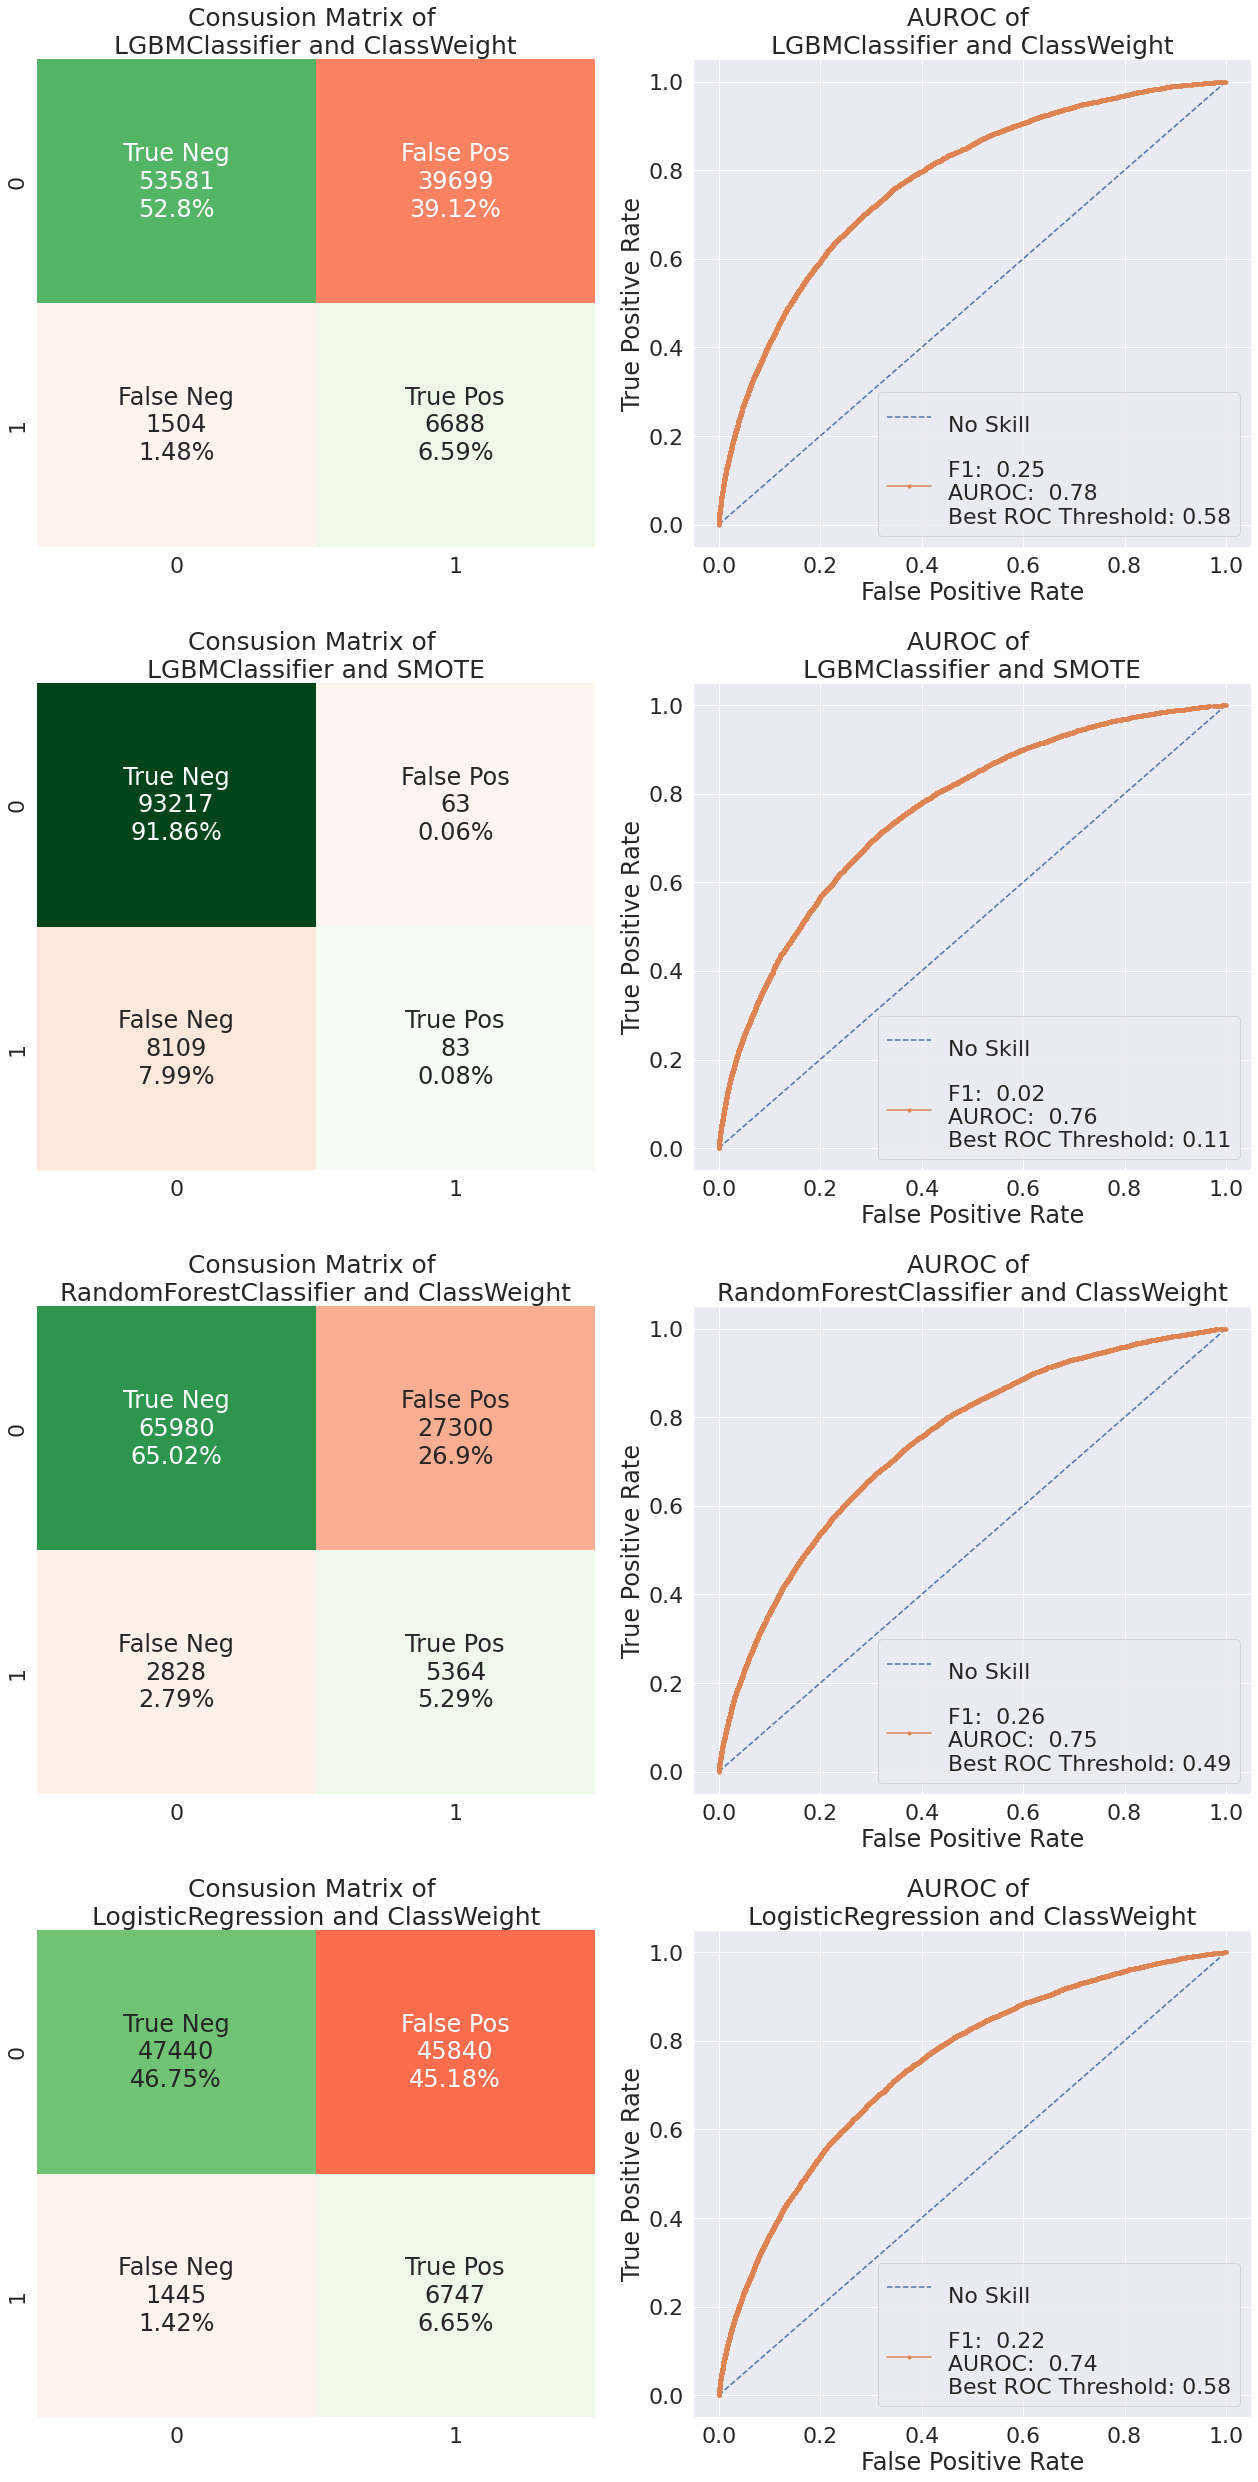

CPU times: user 4.74 s, sys: 363 ms, total: 5.1 s
Wall time: 4.6 s


In [184]:
%%time
# visualize metrics
plot_cm_auroc(winning_model_df_75_vs_25)
plt.show()

# Global Feature Importance

In [3]:
# import model
model = joblib.load("../results/models/recall_90_spec_10/rf_classweight_na.pkl")

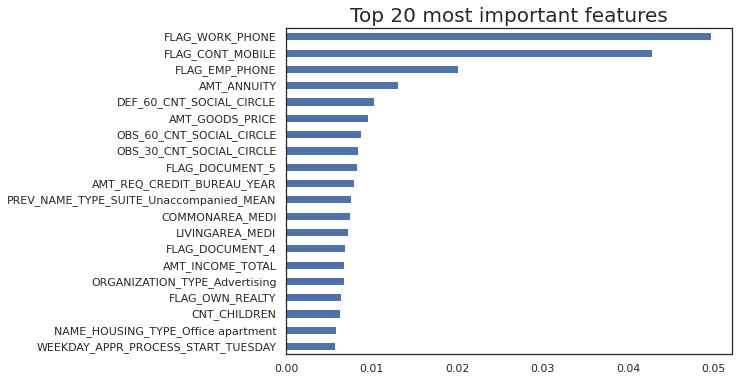

In [12]:
# visualize the 20 most important features from the random forest model
feature_names = X_test.columns
importances = pd.Series(
    model[-1].feature_importances_, index=feature_names
).sort_values(ascending=False)
importances[:20][::-1].plot.barh(figsize=(8, 6))
plt.title("Top 20 most important features", fontsize=20)
plt.show()